In [33]:
import kagglehub
import pandas as pd
import os
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from matplotlib.cm import tab20  # Colormap for distinct colors
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [34]:
path = kagglehub.dataset_download("rajathmc/cornell-moviedialog-corpus")

# Calculate total size of data
total_size = 0
for filename in os.listdir(path):
    if filename.endswith('.txt'):
        file_size = os.path.getsize(os.path.join(path, filename))
        total_size += file_size
print(f"Total size of data: {total_size / (1024 * 1024):.2f} MB")


Total size of data: 40.28 MB


In [35]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

In [36]:
# Load the datasets
movie_lines = pd.read_csv(f"{path}/movie_lines.txt", sep=r' \+\+\+\$\+\+\+ ', header=None,
                          on_bad_lines='skip', encoding='ISO-8859-1', engine='python')
movie_lines.columns = ['LineID', 'CharacterID', 'MovieID', 'CharacterName', 'Text']

movie_conversations = pd.read_csv(f"{path}/movie_conversations.txt", sep=r' \+\+\+\$\+\+\+ ', header=None,
                                  on_bad_lines='skip', encoding='ISO-8859-1', engine='python')
movie_conversations.columns = ['CharacterID1', 'CharacterID2', 'MovieID', 'Conversation']

movie_titles = pd.read_csv(f"{path}/movie_titles_metadata.txt", sep=r' \+\+\+\$\+\+\+ ', 
                          header=None, encoding='ISO-8859-1', engine='python',
                          names=['MovieID', 'Title', 'Year', 'Rating', 'Votes', 'Genres'])

# Strip whitespace from CharacterIDs
movie_lines['CharacterID'] = movie_lines['CharacterID'].str.strip()
movie_conversations['CharacterID1'] = movie_conversations['CharacterID1'].str.strip()
movie_conversations['CharacterID2'] = movie_conversations['CharacterID2'].str.strip()

# Convert to string if necessary
movie_lines['CharacterID'] = movie_lines['CharacterID'].astype(str)
movie_conversations['CharacterID1'] = movie_conversations['CharacterID1'].astype(str)
movie_conversations['CharacterID2'] = movie_conversations['CharacterID2'].astype(str)

# Create a mapping from LineID to CharacterID
line_to_character = dict(zip(movie_lines['LineID'], movie_lines['CharacterID']))


In [37]:
movie_titles.head(5)

,MovieID,Title,Year,Rating,Votes,Genres
0,m0,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
1,m1,1492: conquest of paradise,1992,6.2,10421,"['adventure', 'biography', 'drama', 'history']"
2,m2,15 minutes,2001,6.1,25854,"['action', 'crime', 'drama', 'thriller']"
3,m3,2001: a space odyssey,1968,8.4,163227,"['adventure', 'mystery', 'sci-fi']"
4,m4,48 hrs.,1982,6.9,22289,"['action', 'comedy', 'crime', 'drama', 'thrill..."


In [38]:
movie_conversations.head(5)

,CharacterID1,CharacterID2,MovieID,Conversation
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"


In [39]:
movie_lines.head(5)

,LineID,CharacterID,MovieID,CharacterName,Text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [40]:
# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the style for all plots
plt.style.use('default')  # Default matplotlib style
sns.set_theme()  # Apply seaborn's default styling
sns.set_palette("husl")
sns.set_context("talk")

# Convert 'Votes' and 'Rating' columns to numeric
movie_titles['Votes'] = pd.to_numeric(movie_titles['Votes'], errors='coerce')
movie_titles['Rating'] = pd.to_numeric(movie_titles['Rating'], errors='coerce')

# Capitalize movie titles
movie_titles['Title'] = movie_titles['Title'].str.title()

# Sort movies by Votes and Rating
top_movies = movie_titles.sort_values(['Votes', 'Rating'], ascending=[False, False])

# Select top 20 movies
top_20_movies = top_movies.head(20)


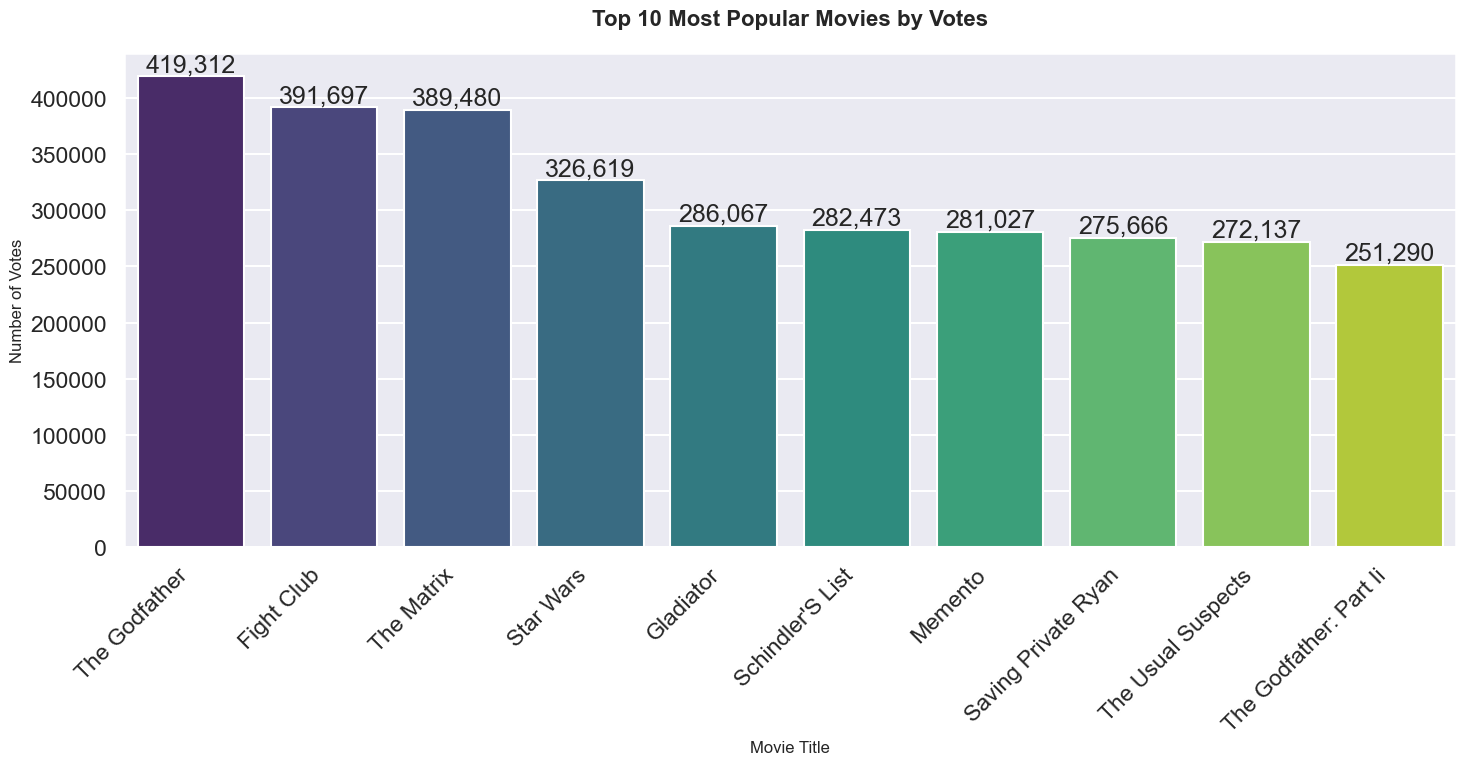

In [41]:
# Bar plot for top 10 movies by votes
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(
    data=top_20_movies.head(10),
    x='Title',
    y='Votes',
    palette='viridis'
)

# Customize the plot
plt.title('Top 10 Most Popular Movies by Votes', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Number of Votes', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(top_20_movies['Votes'].head(10)):
    bar_plot.text(i, v, f'{int(v):,}', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()


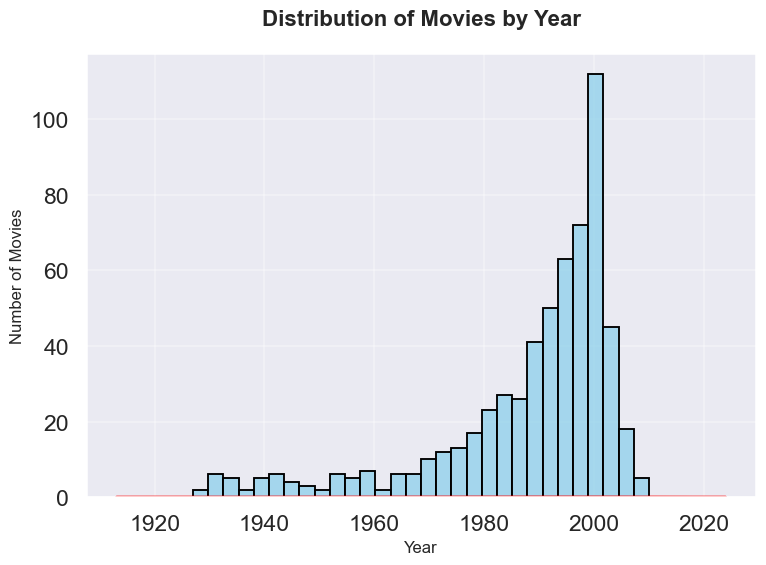

In [42]:
# Histogram for movie year distribution
plt.figure(figsize=(8, 6))
years = pd.to_numeric(movie_titles['Year'], errors='coerce').dropna()

sns.histplot(
    data=years,
    bins=30,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

# Add a kernel density estimate (KDE)
sns.kdeplot(data=years, color='red', linewidth=2)

# Customize the plot
plt.title('Distribution of Movies by Year', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()


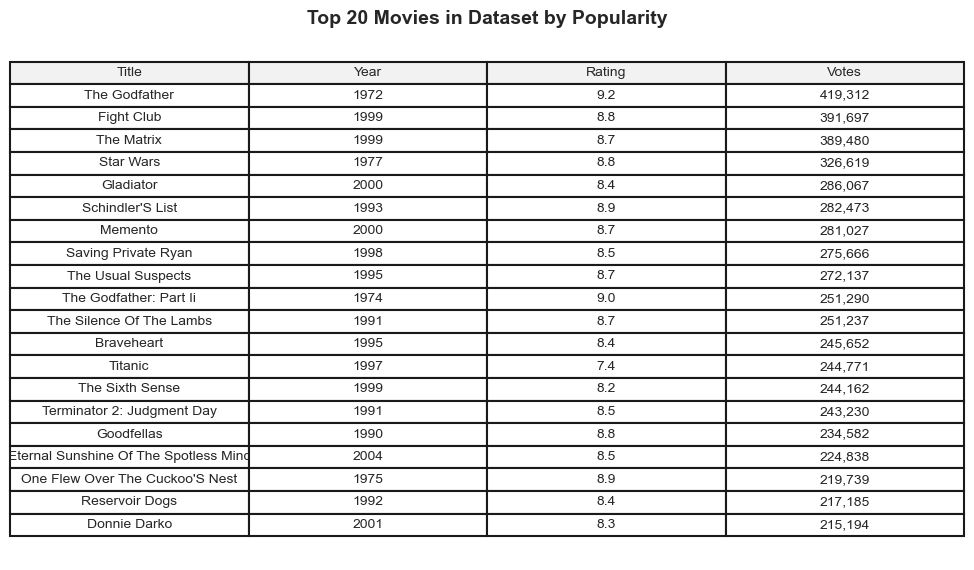

In [43]:
# Table for top 20 movies by popularity
plt.figure(figsize=(10, 6))  # Adjusted figure size for better fit
table_data = top_20_movies[['Title', 'Year', 'Rating', 'Votes']].copy()
table_data['Votes'] = table_data['Votes'].apply(lambda x: f'{int(x):,}')
table_data['Rating'] = table_data['Rating'].round(1)

# Create a table plot
table = plt.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f2f2f2']*4,
    cellColours=[['#ffffff']*4]*len(table_data)
)

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)  # Increase font size slightly for better readability
table.scale(1.2, 1.2)  # Adjust scaling for a compact layout

# Hide axes and reduce spacing
plt.axis('off')

# Adjust title placement
plt.title('Top 20 Movies in Dataset by Popularity', pad=10, fontsize=14, fontweight='bold')

# Use tight layout to reduce unnecessary space
plt.tight_layout(pad=1.0)
plt.show()


### Sentiment Analysis of Movie Dialogues

Sentiment analysis is a technique in natural language processing (NLP) that aims to determine the emotional tone of a given piece of text. It assigns a score to the text, typically ranging from positive to negative, to quantify its sentiment. In the context of movies, sentiment analysis provides valuable insights into the emotional tone of dialogues, helping to understand how the mood of a film evolves over time or how characters express their emotions. This approach can be useful in analyzing the impact of specific lines, characters, or scenes on the overall sentiment of the movie.

For this analysis, the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analyzer is employed. The following code performs sentiment analysis on movie dialogues and aggregates the results to explore the overall sentiment of each movie.

In [44]:
# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Load English stop words
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    tokens = word_tokenize(text)  # Tokenize text
    # Remove stop words and punctuation, convert to lowercase
    cleaned_tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word.isalnum()]
    return " ".join(cleaned_tokens)  # Reconstruct the cleaned text

# Calculate sentiment for all movies
def calculate_all_movie_sentiments(movie_lines, movie_titles):
    # Clean and calculate sentiment for each line
    # Replace None or NaN values in the Text column with an empty string
    movie_lines['Text'] = movie_lines['Text'].fillna("")
    movie_lines['CleanedText'] = movie_lines['Text'].apply(clean_text)
    movie_lines['SentimentScore'] = movie_lines['CleanedText'].apply(lambda text: sia.polarity_scores(text)['compound'])
    
    # Group by MovieID to calculate average sentiment score for each movie
    avg_sentiments = movie_lines.groupby('MovieID')['SentimentScore'].mean().reset_index()
    avg_sentiments.rename(columns={'SentimentScore': 'AverageSentiment'}, inplace=True)
    
    # Merge with MovieTitles to include movie information (Title, Genres, Votes, and Rating)
    merged_df = pd.merge(avg_sentiments, movie_titles, on='MovieID')
    
    # Ensure Votes and Rating columns are numeric for sorting
    merged_df['Votes'] = pd.to_numeric(merged_df['Votes'], errors='coerce')
    merged_df['Rating'] = pd.to_numeric(merged_df['Rating'], errors='coerce')
    
    return merged_df

# Step 2: Filter top 10 movies based on votes and rating
def filter_top_10_movies(all_movies_df):
    # Sort by Votes (descending) and then by Rating (descending)
    top_10_movies = all_movies_df.sort_values(['Votes', 'Rating'], ascending=[False, False]).head(10)
    return top_10_movies

# Formatting for Markdown output
def display_movies(result_df):
    result_df['Genres'] = result_df['Genres'].apply(lambda x: str(x))  # Convert Genres list to string for display
    from tabulate import tabulate
    print(tabulate(result_df[['Title', 'Genres', 'AverageSentiment']], headers='keys', tablefmt='grid'))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/meliscemre/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meliscemre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meliscemre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
all_movies_with_sentiments = calculate_all_movie_sentiments(movie_lines, movie_titles)

top_10_movies = filter_top_10_movies(all_movies_with_sentiments)

display_movies(top_10_movies)

+-----+------------------------+-------------------------------------------------------------+--------------------+
|     | Title                  | Genres                                                      |   AverageSentiment |
+=====+========================+=============================================================+====================+
| 117 | The Godfather          | ['crime', 'drama', 'thriller']                              |        0.0818791   |
+-----+------------------------+-------------------------------------------------------------+--------------------+
| 277 | Fight Club             | ['crime', 'drama', 'mystery', 'thriller']                   |        0.0014068   |
+-----+------------------------+-------------------------------------------------------------+--------------------+
| 372 | The Matrix             | ['action', 'adventure', 'adventure', 'adventure', 'sci-fi'] |        0.0292929   |
+-----+------------------------+----------------------------------------

#### Average Sentiment Analysis by Genre over Decades
The following part of our code analyses how the emotional tone of different movie genres has evolved over decades using sentiment analysis. It combines movie dialogues with genre and release year data, calculates average sentiment scores, and organizes them by decade and genre. The goal is to reveal trends in how genres like Comedy, Drama, and Thriller have shifted emotionally over time, reflecting changes in storytelling and audience preferences.

/var/folders/kw/d6by_1pn7vxf__72gxyh5x800000gn/T/ipykernel_2253/2638033605.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_genres)  # Generate enough distinct colors for all genres


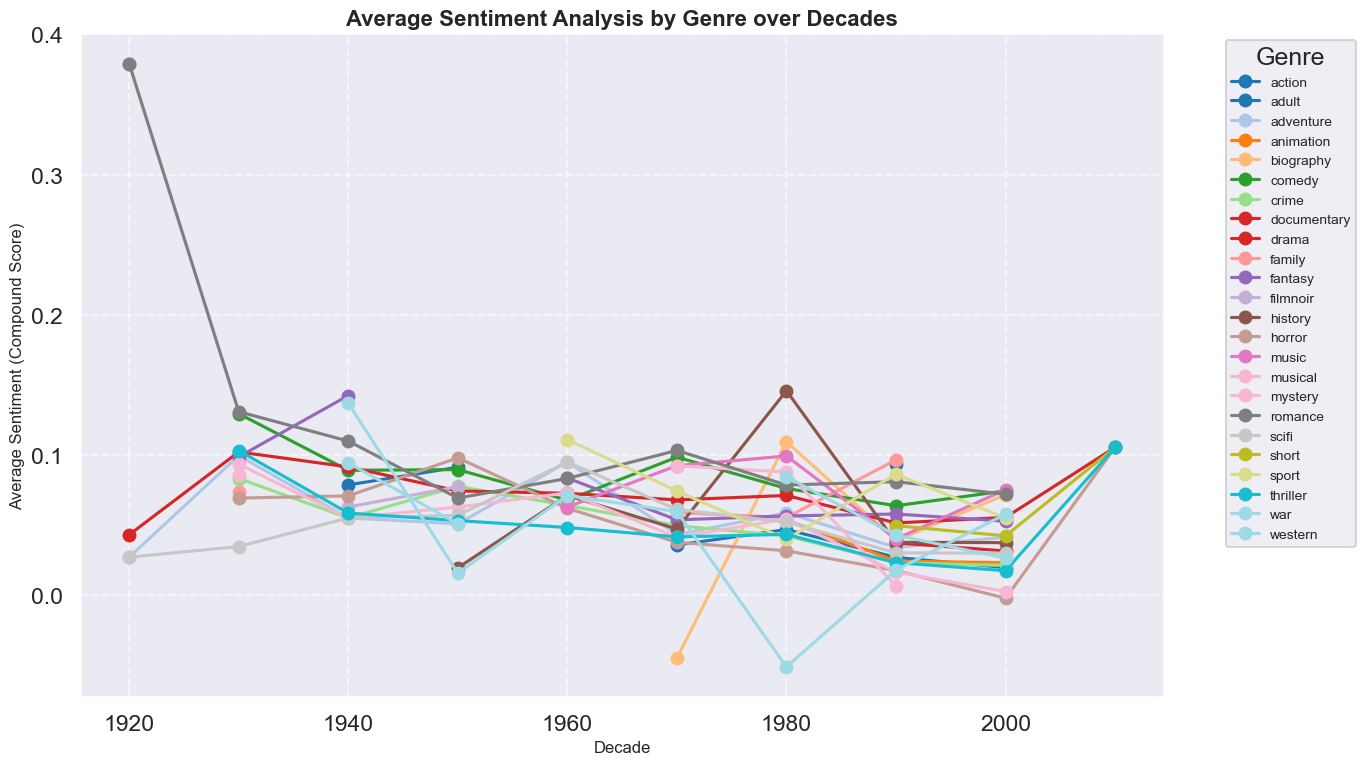

In [46]:

# Merge movie_lines with movie_titles on MovieID
movies_merged_df = movie_lines.merge(all_movies_with_sentiments, on='MovieID')


# Clean the Genres column
movies_merged_df['Genres'] = (
    movies_merged_df['Genres']
    .astype(str)
    .str.replace(r"[^\w\s,]", "", regex=True)  # Remove special characters except commas
    .str.strip()  # Remove leading/trailing whitespace
    .str.lower()  # Convert to lowercase
    .str.split()  # Split into individual words
)

# Explode the Genres column
movies_merged_df = movies_merged_df.explode('Genres')

# Clean again after exploding
movies_merged_df['Genres'] = movies_merged_df['Genres'].str.strip()  # Remove extra spaces
movies_merged_df['Genres'] = movies_merged_df['Genres'].str.replace(r",", "", regex=False)  # Remove any leftover commas

# Filter out empty or malformed genres
movies_merged_df = movies_merged_df[movies_merged_df['Genres'] != ""]
movies_merged_df = movies_merged_df.dropna(subset=['Genres'])  # Drop any NaN values

# Remove duplicate genres (e.g., 'documentary' vs 'documentary,')
movies_merged_df['Genres'] = movies_merged_df['Genres'].str.strip()

# Ensure 'Year' is numeric and calculate decades
movies_merged_df['Year'] = pd.to_numeric(movies_merged_df['Year'], errors='coerce')
movies_merged_df = movies_merged_df.dropna(subset=['Year'])
movies_merged_df['Year'] = movies_merged_df['Year'].astype(int)
movies_merged_df['Decade'] = (movies_merged_df['Year'] // 10) * 10

# Calculate average sentiment by Decade and Genre
decade_sentiment = (
    movies_merged_df.groupby(['Decade', 'Genres'])['AverageSentiment']
    .mean()
    .reset_index()
)

# Pivot the data for plotting (Decades as rows, Genres as columns)
pivot_table = decade_sentiment.pivot(index='Decade', columns='Genres', values='AverageSentiment')

# Assign unique colors dynamically
unique_genres = pivot_table.columns
num_genres = len(unique_genres)
colormap = plt.cm.get_cmap('tab20', num_genres)  # Generate enough distinct colors for all genres

# Create a dictionary mapping each genre to a unique color
genre_colors = {genre: colormap(i) for i, genre in enumerate(unique_genres)}

# Plot sentiment trends for all genres by decade
plt.figure(figsize=(14, 8))

for genre in pivot_table.columns:
    plt.plot(
        pivot_table.index, 
        pivot_table[genre], 
        label=genre, 
        color=genre_colors[genre], 
        marker='o'  # Add markers for better readability
    )

# Customize the plot
plt.title('Average Sentiment Analysis by Genre over Decades', fontsize=16, fontweight='bold')
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Average Sentiment (Compound Score)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=10)

# Final layout adjustments
plt.tight_layout()
plt.show()

The plot above visualizes the average sentiment trends of movie genres over decades. The x-axis represents the decades, starting from the earliest available data while the y-axis shows the average compound sentiment score, derived from analyzing the emotional tone of dialog across movies.

Most genres shows relatively stable sentiment scores, which suggests that while the tone may vary, the average sentiment within genres remains consistent across time. However, some genres show sharp peaks and dips in sentiment during specific decades. The reason for this can be the influence of historical events or cultural shifts.

The genres *"Romance"* and *"Comedy"* display consistently positive sentiment across decades, reflecting their inherently cheerful and lighthearted themes. The *War* genre shows significant variability across decades, with a noticeable dip in sentiment scores during the 1980s, reaching the most negative value on the graph. This could be reflective of the themes and tone of war movies during this time. *"Thriller"* genre tends to cluster toward the lower range of sentiment scores across all decades. This aligns with the nature of the genre, which often relies on suspense, fear, and tension to drive their narratives.

After 2000s, several genres show a clear upward trend in sentiment scores. This could be indicative of a shift toward more uplifting, family-friendly, or optimistic storytelling in modern cinema. For example, studios like Pixar and DreamWorks popularized feel-good, emotionally engaging stories. Moreover, interest in lighthearted romantic comedies rose, too. Interestingly, even traditionally darker genres like *"War"* show slight increases in sentiment post-2000. This can be an indicator of change in audience preference. 

#### Sentiment of Individual Dialogues in a Specific Movie

Analyzing individual movies allows us to track how the emotional tone evolves throughout the film, providing insights into its narrative structure and character development. By plotting the sentiment of each dialogue and the cumulative average sentiment over time, we can observe shifts in mood, such as rising tension and emotional peaks. The plot also includes a neutral sentiment line for comparison, making it easier to see whether the film leans positive or negative overall. Additionally, a heatmap visualizes the sentiment distribution, highlighting patterns or clusters of emotional intensity within the movie.

/var/folders/kw/d6by_1pn7vxf__72gxyh5x800000gn/T/ipykernel_2253/3596310941.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_lines_filtered['LineID_numeric'] = movie_lines_filtered['LineID'].str.extract('(\d+)').astype(int)


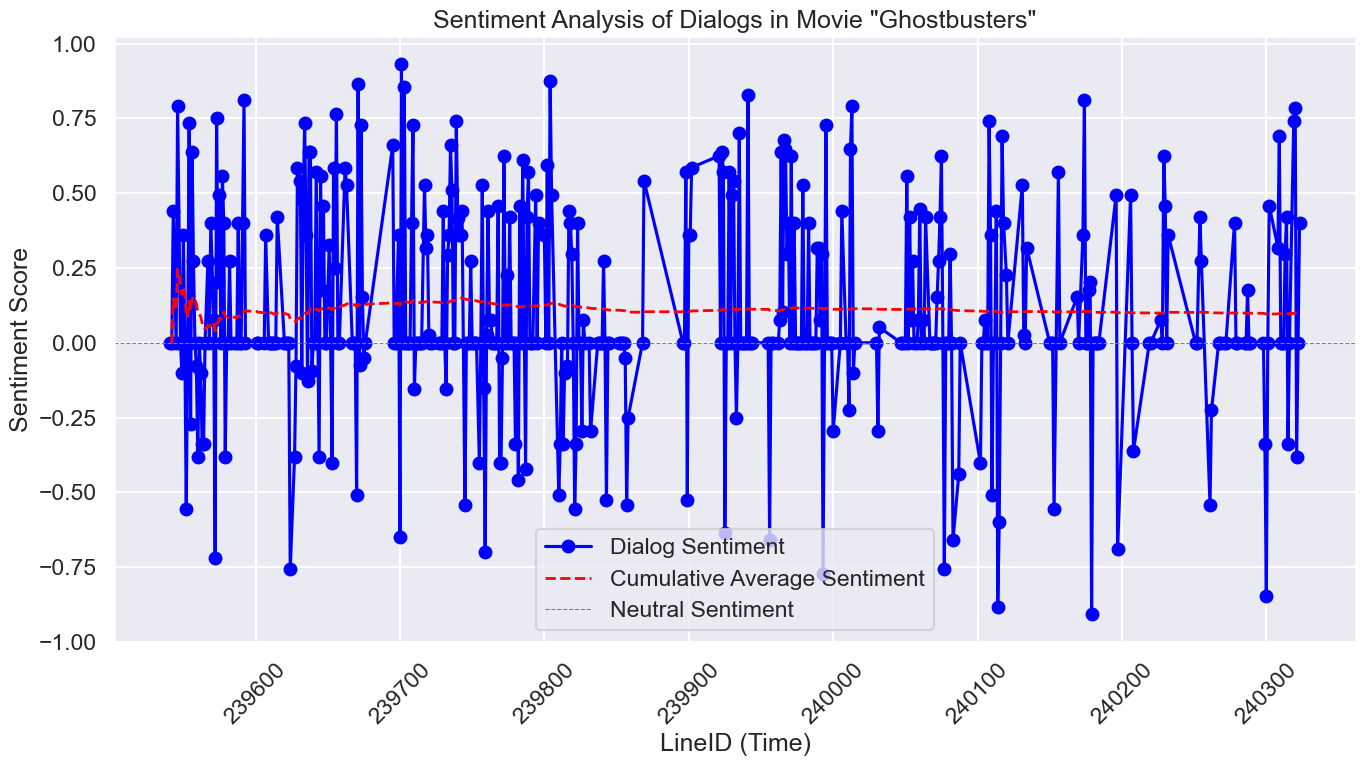

In [48]:
# Filter data for the specific movie
movie_id_to_analyze = "m75"

# Extract the movie title
movie_title = movie_titles.loc[movie_titles['MovieID'] == movie_id_to_analyze, 'Title'].values[0]
movie_lines_filtered = movie_lines[movie_lines['MovieID'] == movie_id_to_analyze]

# Extract numeric part of LineID and add as a new column
movie_lines_filtered['LineID_numeric'] = movie_lines_filtered['LineID'].str.extract('(\d+)').astype(int)

#  Sort by the numeric LineID to ensure chronological order
movie_lines_filtered = movie_lines_filtered.sort_values(by='LineID_numeric').reset_index(drop=True)

# Use the already calculated sentiment scores
movie_lines_filtered['Sentiment'] = movie_lines_filtered['SentimentScore']  # Use pre-calculated sentiment

# Calculate cumulative average sentiment
movie_lines_filtered['CumulativeAverage'] = movie_lines_filtered['Sentiment'].expanding().mean()

# Step 6: Plot sentiment score and cumulative average over time
plt.figure(figsize=(14, 8))

# Plot individual dialog sentiment
plt.plot(
    movie_lines_filtered['LineID_numeric'],
    movie_lines_filtered['Sentiment'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Dialog Sentiment'
)

# Plot cumulative average sentiment
plt.plot(
    movie_lines_filtered['LineID_numeric'],
    movie_lines_filtered['CumulativeAverage'],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Cumulative Average Sentiment'
)

# Add a neutral sentiment line
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, label='Neutral Sentiment')

# Add labels, legend, and title
plt.title(f'Sentiment Analysis of Dialogs in Movie "{movie_title}"')
plt.xlabel('LineID (Time)')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.legend()

# Format the x-axis to show intermittent values and rotate labels
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='both'))  # Show a manageable number of x-ticks
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The plot above shows the sentiment analysis of Ghostbusters, illustrating the emotional shifts throughout the movie.

Ghostbusters maintains a dynamic emotional tone, mixing humor with moments of tension and drama. The movie balances light-hearted, funny scenes with some more serious or spooky moments, especially during ghost encounters. Overall, the sentiment remains mostly positive, reflecting its reputation as a family-friendly comedy-adventure. While it does include occasional intense elements, they are presented in a way that keeps the movie fun and entertaining for a broad audience.

<Axes: >

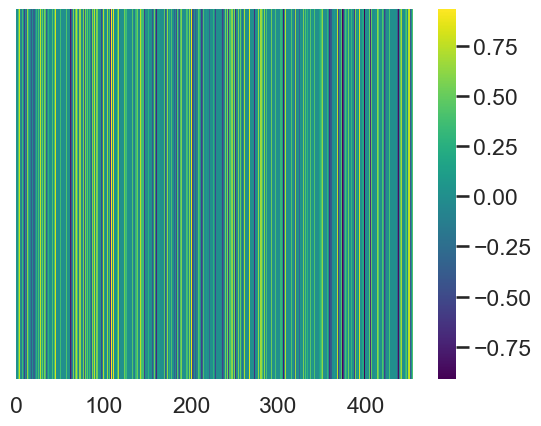

In [49]:
import seaborn as sns

sns.heatmap(
    movie_lines_filtered[['Sentiment']].T, 
    cmap='viridis', 
    cbar=True, 
    xticklabels=100, 
    yticklabels=False
)


The heat map above aligns with the previous line graph, further supporting the observations of Ghostbusters' sentiment analysis. Darker colors, representing negative sentiment, are sparse, while lighter colors, indicating positive or neutral sentiment, are more prevalent. This visualization reinforces the movie's overall positive tone, balancing its humor and occasional moments of tension in an engaging and family-friendly way.

### **Calculating and Visualizing TF-IDF for the Genres**

To understand the unique themes that define each genre, Term Frequency-Inverse Document Frequency (TF-IDF) is calculated for the movie genres.

The purpose of following code is:

1. **Extract Content by Genre:** The text content from each genre is collected by grouping the dialogues by genre. Special characters are removed, and the genres are split into individual words.

2. **Compute Term Frequency (TF):** The frequency of each word within each genre is calculated using logarithmic normalization to reduce the impact of very common terms.

3. **Calculate Inverse Document Frequency (IDF):** IDF values are calculated to determine how unique each word is across genres, down-weighting words that appear frequently across many genres.

4. **Calculate TF-IDF:** TF and IDF values are combined to score the importance of each word in distinguishing the genres.

5. **Visualize Top Words:** A table is generated that displays the top 10 TF-IDF words for each genre, showing the most important words that define the unique themes of each genre.

This process helps identify the distinctive vocabulary that characterizes each genre, providing valuable insights into the language and themes commonly associated with different genres in movies.

In [50]:
# Merge and clean genres
movies_genre_dialogs = movie_lines.merge(movie_titles[['MovieID', 'Genres']], on='MovieID', how='inner')

movies_genre_dialogs['Genres'] = (
    movies_genre_dialogs['Genres']
    .astype(str)
    .str.replace(r"[^\w\s,]", "", regex=True)  # Remove special characters except commas
    .str.strip()  # Remove leading/trailing whitespace
    .str.lower()  # Convert to lowercase
    .str.split()  # Split into individual words
)

movies_genre_dialogs = movies_genre_dialogs.explode('Genres')

movies_genre_dialogs['Genres'] = movies_genre_dialogs['Genres'].str.strip()  # Remove extra spaces
movies_genre_dialogs['Genres'] = movies_genre_dialogs['Genres'].str.replace(r",", "", regex=False)  # Remove commas
movies_genre_dialogs = movies_genre_dialogs.dropna(subset=['Genres'])  # Drop NaN genres
movies_genre_dialogs['Genres'] = movies_genre_dialogs['Genres'].astype(str)  # Ensure genres are strings

# Accumulate text for each genre
genres_texts = defaultdict(str)
for _, row in movies_genre_dialogs.iterrows():
    genre = row['Genres']
    content = row['CleanedText']  # Assuming 'CleanedText' already exists
    if genre and content:
        genres_texts[genre] += " " + content  # Accumulate dialogs for each genre

# Calculate Term Frequency (TF) for each genre
tf_by_genre = {}
for genre, text in genres_texts.items():
    word_counts = Counter(text.split())
    tf_by_genre[genre] = {word: 1 + math.log(count) for word, count in word_counts.items()}  # Logarithmic TF

# Calculate Inverse Document Frequency (IDF)
total_genres = len(genres_texts)
df_counts = Counter()
for text in genres_texts.values():
    unique_words = set(text.split())
    for word in unique_words:
        df_counts[word] += 1

idf = {word: math.log(total_genres / df_count) for word, df_count in df_counts.items()}  # Calculate IDF

# Calculate TF-IDF for each genre
tfidf_by_genre = {}
for genre, tf_values in tf_by_genre.items():
    tfidf_by_genre[genre] = {word: tf * idf[word] for word, tf in tf_values.items()}  # TF-IDF calculation

# Extract top 10 TF-IDF words for each genre
top_words_by_genre = {}
for genre, tfidf in tfidf_by_genre.items():
    sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_tfidf[:10]
    top_words_by_genre[genre] = top_words

# Prepare data for the table
table_data = []
for genre, words in top_words_by_genre.items():
    words = [f"{word} ({score:.2f})" for word, score in words]  # Format words with their scores
    table_data.append(words)

# Create a DataFrame with the top 10 words for each genre
df = pd.DataFrame(table_data, index=[str(genre).title() for genre in top_words_by_genre.keys()],
                  columns=[f"Word #{i+1}" for i in range(10)])
df.index.name = "Movie Genre"

# Configure pandas to display all columns and rows
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)  # Expand display width
pd.set_option('display.colheader_justify', 'left')  # Left-align column headers

# Display the DataFrame
print(df)

            Word #1            Word #2             Word #3             Word #4             Word #5             Word #6            Word #7             Word #8            Word #9             Word #10         
Movie Genre                                                                                                                                                                                                   
Comedy        gardiner (13.18)       shari (12.85)      dignan (12.53)  bialystock (12.36)   ninotchka (12.05)    windham (11.78)       hildy (11.74)      talia (11.57)   mordechai (11.57)     jabez (11.41)
Romance      ninotchka (12.05)    preysing (11.89)       hildy (11.74)  kringelein (11.46)      vivian (11.25)     jeanne (11.03)       swana (10.77)     lawson (10.63)  manchester (10.38)   marylin (10.30)
Adventure          neo (10.28)        duval (9.21)        benes (9.04)        magua (9.01)     morpheus (8.87)        erik (8.77)    narcissus (8.51)        indy (8.36)    

The table lists the top 10 words for each movie genre, and it is immediately apparent that these words are predominantly character names. The TF-IDF scores highlight these character names as important and distinctive to each genre, meaning they are used frequently within the context of the genre and are less common across other genres.

For instance, in the *adventure* genre, the name Neo stands out as one of the top words. This is a clear reference to Neo from The Matrix, one of the most iconic characters in action-adventure cinema. Similarly, Morpheus, another character from The Matrix, also makes the list for the *adventure* genre, reinforcing the centrality of character-driven narratives in these films.

In genre *crime*, we see Clarice and Lecter—likely referring to Clarice Starling and Hannibal Lecter from The Silence of the Lambs. These two characters are iconic in the crime and thriller genres.

In conclusion, the table reveals that genre-specific character names play a significant role in defining the essence of each genre. This demonstrates that characters are not only central to the plot but also to the identity of the genre itself. The TF-IDF analysis has effectively identified these iconic characters as fundamental elements of each genre's dialogue and thematic structure.

To better understand these patterns visually, we can use word clouds. Word clouds are an excellent way to display the most important words for each genre, with the size of each word reflecting its significance based on TF-IDF scores. These visualizations allow us to quickly grasp the defining vocabulary of each genre and see how character names dominate the top words across different categories.



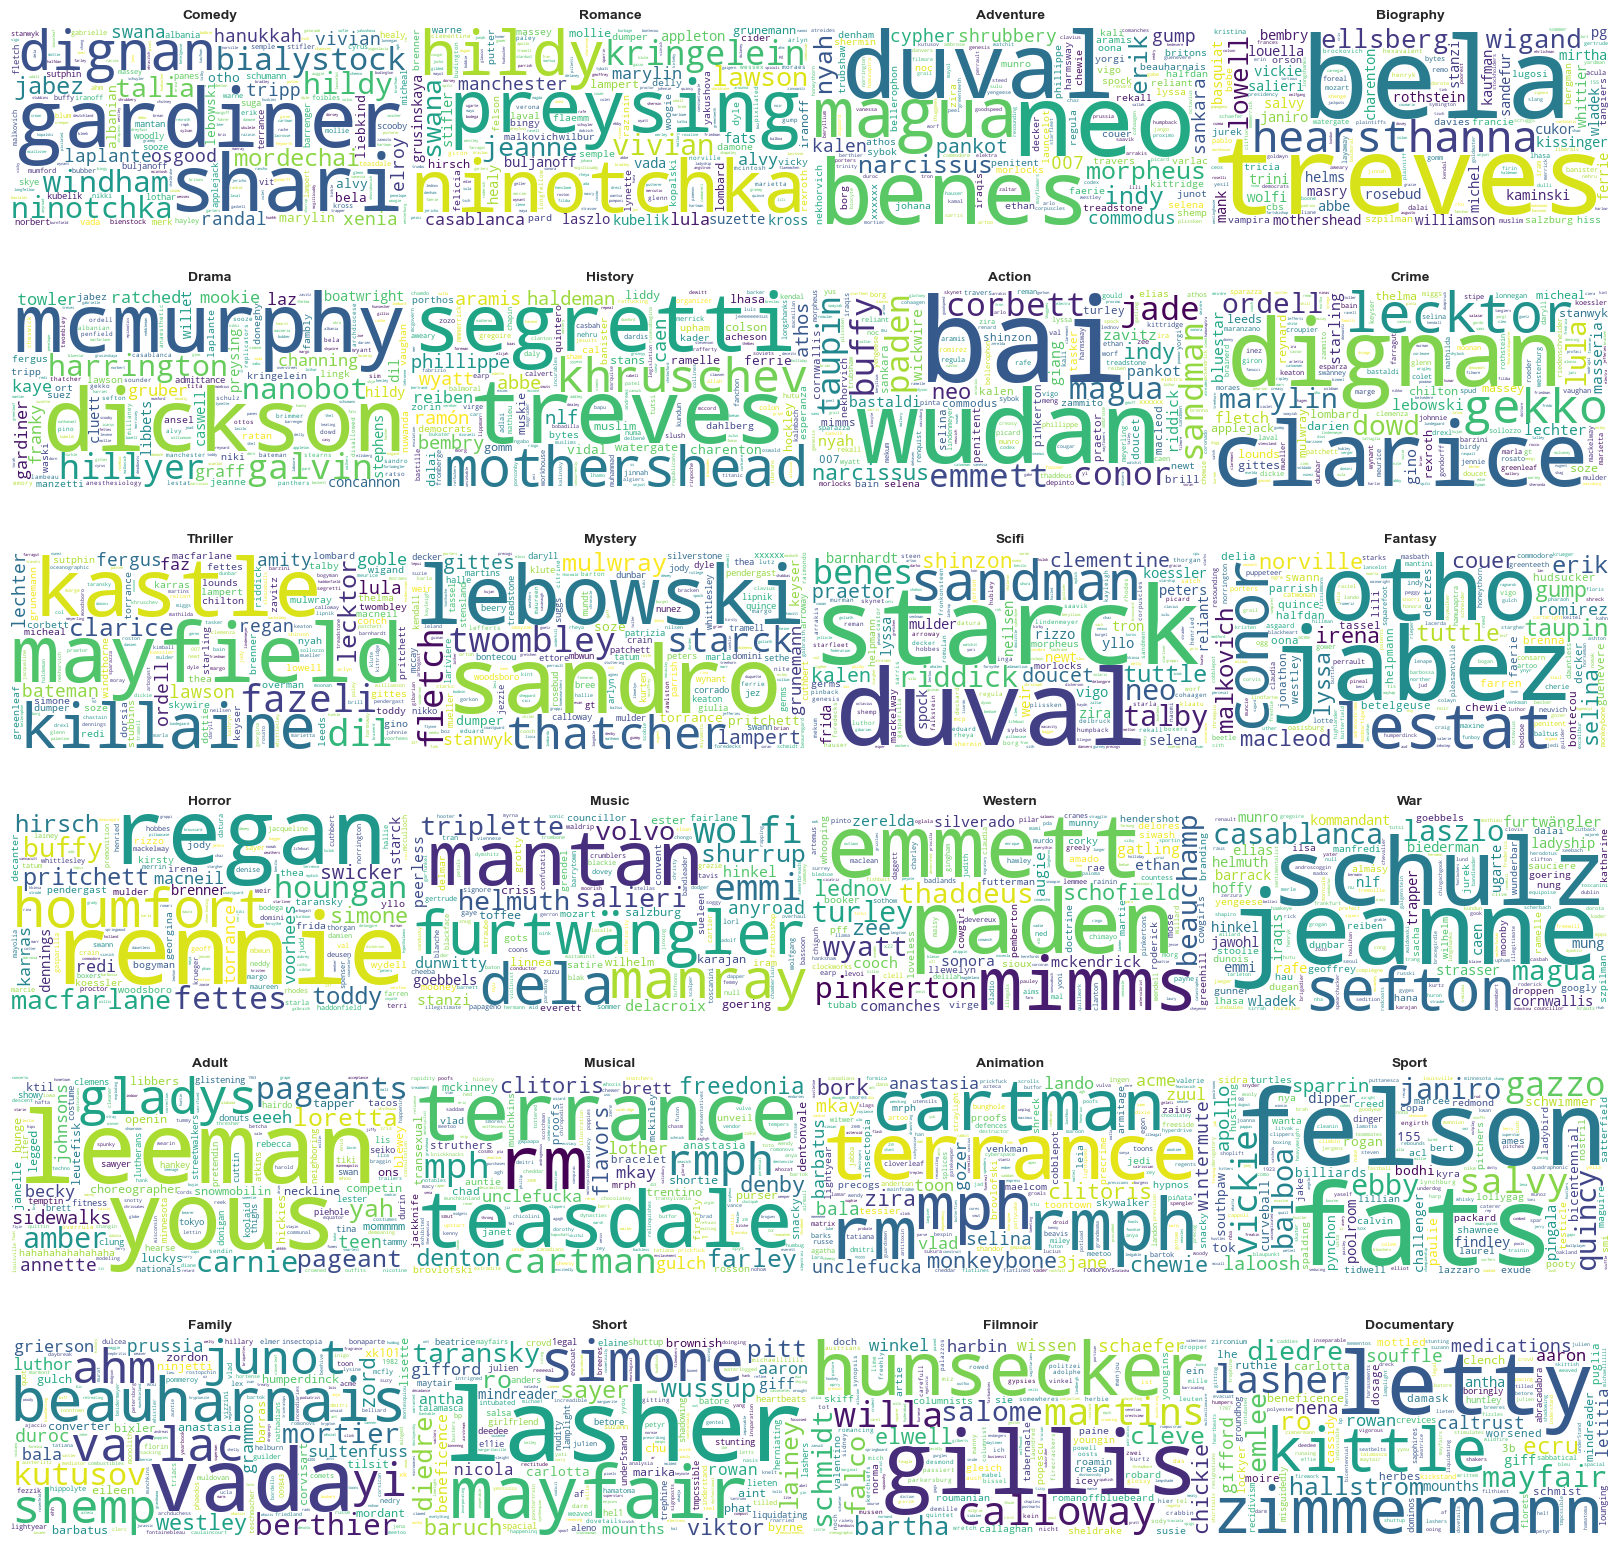

In [60]:
# Prepare word frequencies for each genre
genre_wordcloud_data = {}
for genre, tfidf_scores in tfidf_by_genre.items():
    # Use TF-IDF scores as word weights
    word_weights = {word: score for word, score in tfidf_scores.items()}
    genre_wordcloud_data[genre] = word_weights

# Define the number of rows and columns for the grid
rows, cols = 6, 4  # 6 rows and 4 columns
all_genres = list(genre_wordcloud_data.keys())

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))  # Adjust figsize for tighter plots
axes = axes.flatten()  # Flatten the axes for easy iteration

# Generate word clouds and plot them
for idx, genre in enumerate(all_genres):
    wordcloud = WordCloud(
        width=400, height=200,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(genre_wordcloud_data[genre])
    
    # Plot the word cloud in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"{genre.title()}", fontsize=10, fontweight='bold')

# Turn off remaining empty subplots if there are fewer genres than grid slots
for i in range(len(all_genres), len(axes)):
    axes[i].axis('off')

# Step 4: Adjust layout for minimal spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Further reduce space between subplots
plt.tight_layout(pad=0.0)  # Tighten the layout with padding
plt.show()
